# Genome IGR Analysis Report 
---
## Purpose
This sheet serves to compile the results of several analytical programs run to analyze the output of a selected IGR into one easily viewable location. 

The information compiled includes:
* Number of hits
* Structure predicted by R-scape
* Structure predicted by CMfinder
* Possible sub-structures highlighted by CMfinder
* Gene Association
* Examples of specific gene context

### Necessary code imports and Preparation

In [1]:
from Bio import AlignIO, SeqIO
import random
import subprocess
import os
import pandas as pd
import glob
import re
import tarfile
import ipywidgets


%cd /home/jovyan/work
from src.data.genome_context import get_all_images, run_rscape, tar_subdir_members, build_target_coords

/home/jovyan/work


## Step 1 
---
Change the variable `import_tar_name` and `step_name` below to reflect the data being imported.

In [2]:
# Change the variables here to reflect data being imported
import_tar_name = "data/import/Francisella_tularensis_GCA_000008985.1_selection_0.5_2.0_-2.0_infernal_step1.done.tar.gz"
assembly_acc = "GCA_000008985.1"
selection_name = "selection_0.5_2.0_-2.0"
step_name = 'infernal_step1'

# Unpack the files 
untar_dir = "data/interim/genomes/{}/{}".format(assembly_acc, selection_name)        
with tarfile.open(import_tar_name, "r:gz") as tar:
    tar.extractall(path=untar_dir, members=tar_subdir_members(tar, import_tar_name))

### Collect all the potential motifs in the imported directory and generate selection dropdown

In [3]:
data_dir="{}/{}".format(untar_dir, step_name)
tblout_files = glob.glob("{}/*/*.tblout".format(data_dir))        
motif_list = list(file.split('/')[-1][:-10] for file in tblout_files)
motif_dropdown = ipywidgets.Dropdown(options=motif_list, description="Motif Name",  layout={'width': 'max-content'})
motif_dropdown

Dropdown(description='Motif Name', layout=Layout(width='max-content'), options=('AJ749949_1041004-1041510_igr'…

## Step 2
---
After selecting an IGR from the dropdown above, run all cells starting at this codeblock to generate the analysis data.

In [4]:
# Saves the next motif in the list of motifs to motif_name
motif_name=motif_dropdown.value
outdir="{}/{}".format(data_dir,motif_name)
sto_filename = "{}/{}.cm.align.sto".format(outdir, motif_name)
dedupe_filename = "{}/{}.dedupe.fasta".format(outdir, motif_name)
sample_filename = "{}/{}.sample.fasta".format(outdir, motif_name)
results_filename ="{}/{}.cm.tblout".format(outdir, motif_name) 

# Read in the results from the .tblout file
results_df = pd.read_csv(results_filename, skiprows=2, skipfooter=10, sep='\s+', engine='python', header=None, 
                         names=['target_name', 'target_accession', 'query_name', 'query_accession', 'mdl', 'mdl_from', 'mdl_to', 
                                'seq_from', 'seq_to', 'strand', 'trunc', 'pass', 'gc', 'bias', 'score', 'e_value', 'inc','description'])
# Remove duplicate accession numbers caused by duplicates in the searched database
results_df.drop_duplicates(inplace=True)

# Correct coordinates taking IGR database into account
results_df['target_coords'] = results_df.apply(lambda row: build_target_coords(row['target_name'], row['seq_from'], row['seq_to']), axis=1)
results_df.drop(columns=['target_accession', 'query_accession', 'inc', 'description', 'query_name'], inplace=True)

# Remove duplicate entries from the database
dedupe_fasta = list(SeqIO.parse(dedupe_filename, 'fasta'))
#   Remove nn| prefix (if found) before adding id to list
dedupe_id_list = [(re.sub('^[0-9]+\|','',record.id)) for record in dedupe_fasta]
deduped_results_df = results_df[results_df['target_coords'].isin(dedupe_id_list)].copy()

# Output results
print("Results for: {}".format(motif_name))
print("Number of Unique Hits: {}".format(len(dedupe_id_list)))

# Display up to 100 rows
with pd.option_context('display.max_rows', 100):
    display(deduped_results_df[['e_value', 'target_coords', 'gc', 'bias', 'score', 'strand', ]])

Results for: AJ749949_1041004-1041510_igr
Number of Unique Hits: 27


,e_value,target_coords,gc,bias,score,strand
0,1.800000e-138,NZ_DS264119.1/394379-394884,0.26,32.4,475.6,+
43,8.300000e-138,NC_016933.2/1116853-1117358,0.26,32.8,473.4,+
45,2.100000e-137,NC_010677.1/1002745-1002240,0.26,32.5,472.1,-
49,2.100000e-136,NZ_CZDH02000006.1/22643-22138,0.26,32.8,468.8,-
602,4.800000e-135,NZ_VJCD01000004.1/22851-22347,0.26,33.7,464.4,-
603,9.500000e-135,NZ_CP021490.1/1177111-1176608,0.26,32.4,463.4,-
604,1.800000e-130,NC_017450.1/963040-963538,0.26,32.9,449.3,+
605,1.700000e-129,NZ_DS989818.1/700908-701427,0.26,32.9,446.2,+
610,1.900000e-129,NZ_DS995363.1/558307-558824,0.27,31.2,446.0,+
611,9.400000e-128,NZ_CP016635.1/970401-970914,0.27,32.0,440.4,+


## R-scape Structure Prediction from Co-variation

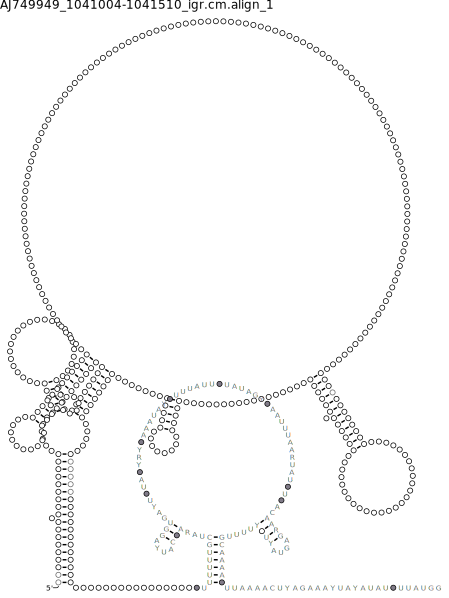

In [5]:
run_rscape(outdir, sto_filename, fold=True, output=False)

### CMfinder Motif Discovery

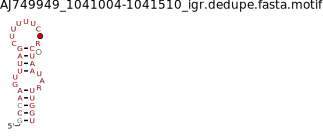

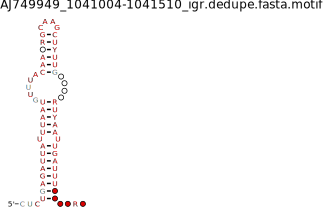

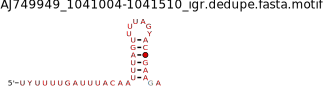

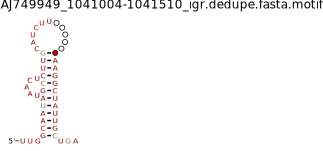

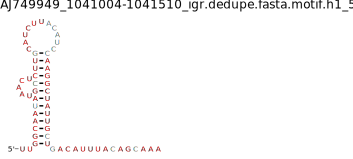

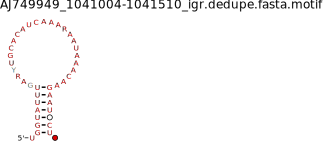

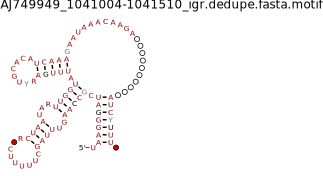

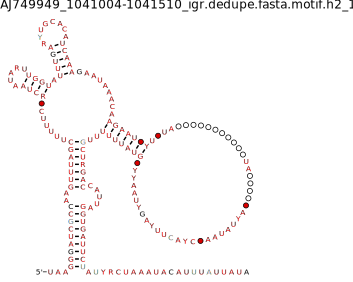

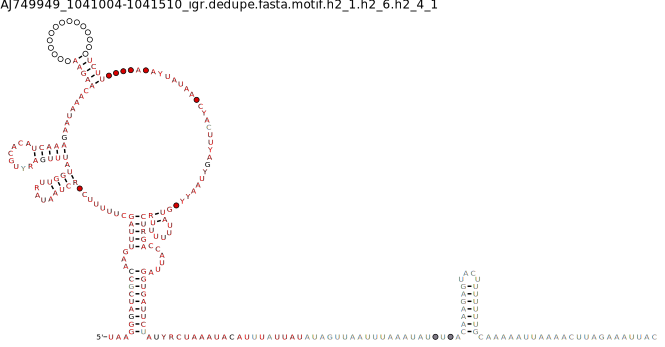

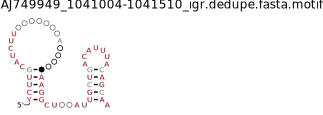

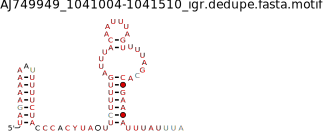

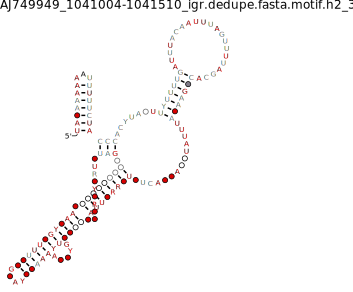

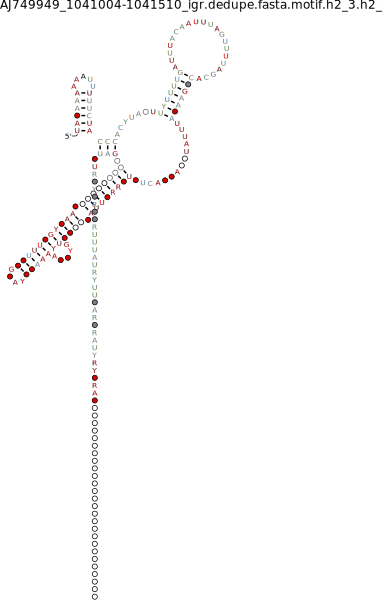

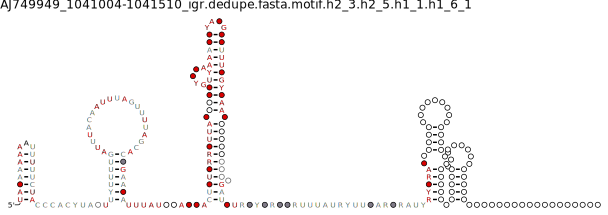

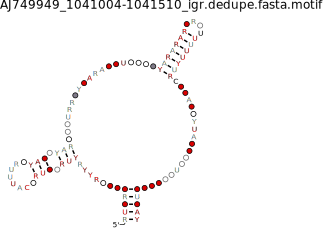

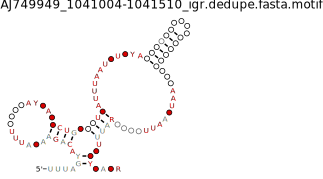

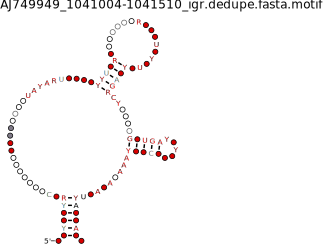

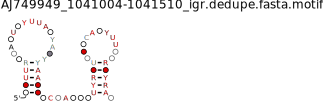

In [6]:
import os

def check_motif(motif):
    for fragment in ['cov', 'dplot', 'power', 'R2R', 'sorted', 'surv', 'temp.gap', 'svg', 'ps']:
        if fragment in motif:
            return False
    return True

motif_files = glob.glob("{}/{}/*fasta.motif*".format(data_dir, motif_name))
# Get the list of all the motif portions predicted by cmfinder
cmfinder_motifs = [file[file.rfind('motif')+6:] for file in motif_files]
# Remove duplicates
cmfinder_motifs = list(set(cmfinder_motifs))
# Remove motifs with '.temp.gap'
cmfinder_motifs = [ motif for motif in cmfinder_motifs if check_motif(motif)]

completed_motifs = []

cmfinder_motifs.sort()
for motif in cmfinder_motifs:
    file = "{}/{}.dedupe.fasta.motif.{}".format(outdir, motif_name, motif)
    if file[-4:] != '.sto':
        os.rename(file, "{}.sto".format(file))
        file = "{}.sto".format(file)
    if file not in completed_motifs:
        run_rscape(outdir, file, fold=False, output=False)
        completed_motifs.append(file)
    
all_files = glob.glob("{}/{}/*".format(data_dir, motif_name))


### RNAcode Analysis for Possible Protein Coding Regions

In [7]:
clustal_filename = "{}/{}/{}.sample.clustal".format(data_dir,motif_name, motif_name) 

sample_fasta = list(SeqIO.parse(sample_filename, 'fasta'))
sample_id_list = [record.id for record in sample_fasta]
sto_records = list(SeqIO.parse(sto_filename, 'stockholm'))
sampled_sto_records = [record for record in sto_records if record.id in sample_id_list]

alignment = sampled_sto_records[:200]

with open(clustal_filename, 'w') as clustal_file:
    SeqIO.write(alignment, clustal_file, "clustal")
    
output = subprocess.run(['RNAcode', clustal_filename], capture_output=True)

print(output.stdout.decode())
print(output.stderr.decode())


 HSS # Frame Length  From    To        Name       Start         End    Score        P
     0    -1     11   155   165NZ_DS264119.1/394379-394884         463         495     3.00    0.565
     1    -3      4    86    89NZ_DS264119.1/394379-394884         258         269     1.44    0.995
     2    -3      4   150   153NZ_DS264119.1/394379-394884         450         461     1.35    0.997
     3    -3      4    37    40NZ_DS264119.1/394379-394884         111         122     1.11    1.000
     4    -3      4    14    17NZ_DS264119.1/394379-394884          42          53     1.10    1.000
     5    +1      7   136   142NZ_DS264119.1/394379-394884         406         426     0.97    1.000
     6    +3      5    49    53NZ_DS264119.1/394379-394884         147         161     0.88    1.000
     7    +2      4    80    83NZ_DS264119.1/394379-394884         239         250     0.80    1.000
     8    +2      4   150   153NZ_DS264119.1/394379-394884         449         460     0.78    1.000
    

## Genome Context Images

---

Match #1
E-value:          1.7999999999999986e-138
%GC:              0.26
Score:            475.6
Target:           NZ_DS264119.1/394379-394884
Genome Assembly:  GCF_000154165.1_ASM15416v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. tularensis
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCAAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


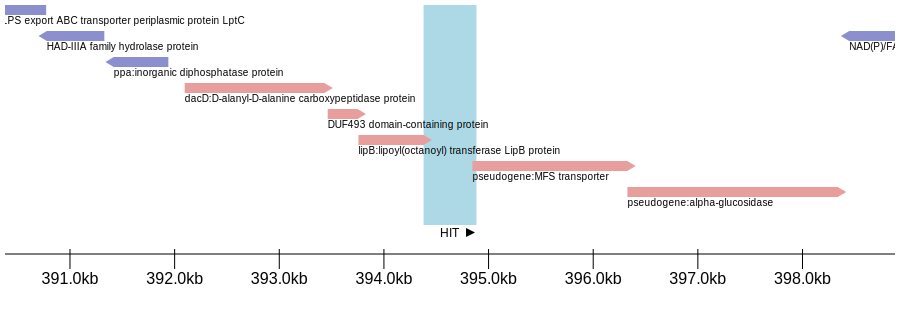

---

Match #44
E-value:          8.29999999999999e-138
%GC:              0.26
Score:            473.4
Target:           NC_016933.2/1116853-1117358
Genome Assembly:  GCF_000248415.2_ASM24841v2
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. tularensis; Francisella tularensis subsp. tularensis TI0902
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCAAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCAUAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


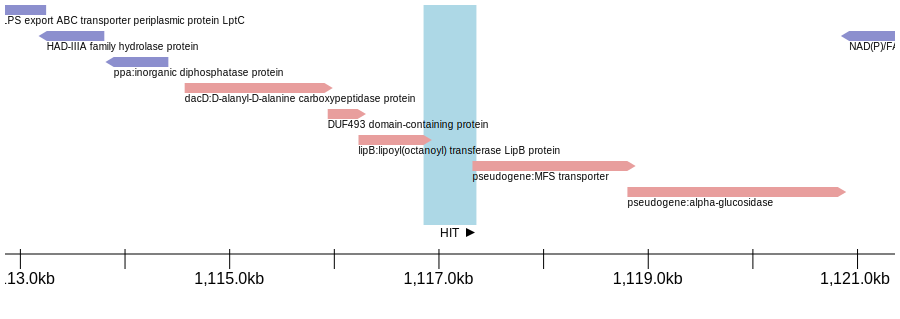

---

Match #46
E-value:          2.0999999999999968e-137
%GC:              0.26
Score:            472.1
Target:           NC_010677.1/1002745-1002240
Genome Assembly:  GCF_000018925.1_ASM1892v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. mediasiatica
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUAUCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


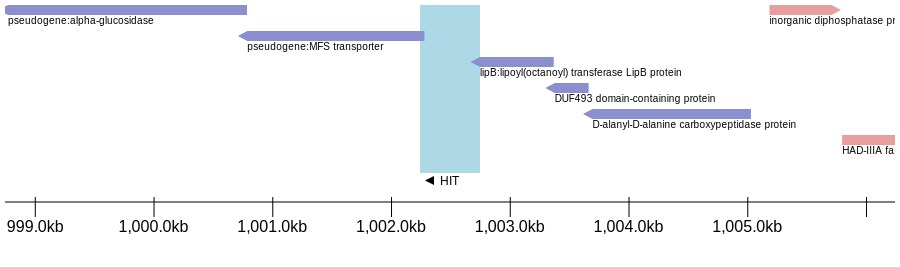

---

Match #50
E-value:          2.099999999999997e-136
%GC:              0.26
Score:            468.8
Target:           NZ_CZDH02000006.1/22643-22138
Genome Assembly:  GCF_900016285.2_ANSES_11-930-9S
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAAAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUACUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


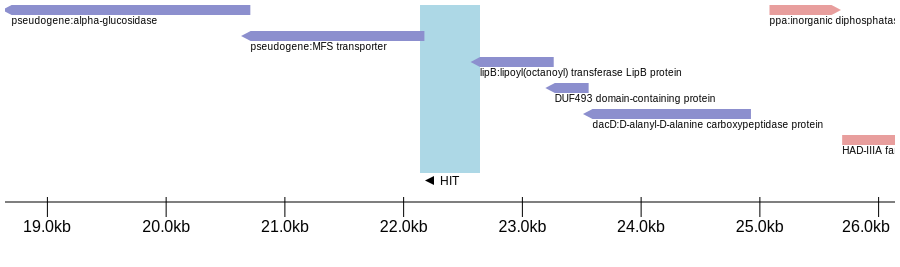

---

Match #603
E-value:          4.799999999999999e-135
%GC:              0.26
Score:            464.4
Target:           NZ_VJCD01000004.1/22851-22347
Genome Assembly:  GCF_009814225.1_ASM981422v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUUAACUGCACAUCAAAAAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUACUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUG


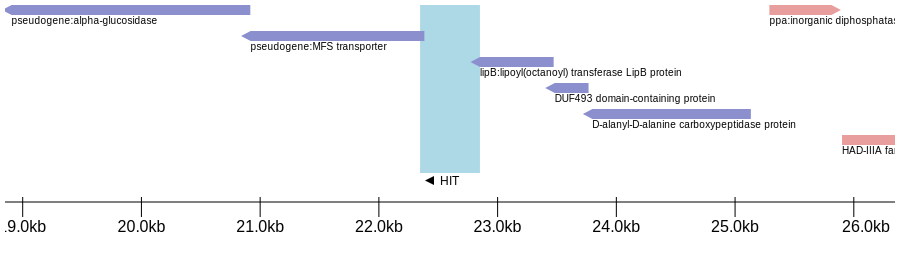

---

Match #604
E-value:          9.499999999999984e-135
%GC:              0.26
Score:            463.4
Target:           NZ_CP021490.1/1177111-1176608
Genome Assembly:  GCF_002952075.1_ASM295207v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis
Matched Sequence: AUUAUGGUUUUUAUUAAUUAAACUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGAUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUACCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


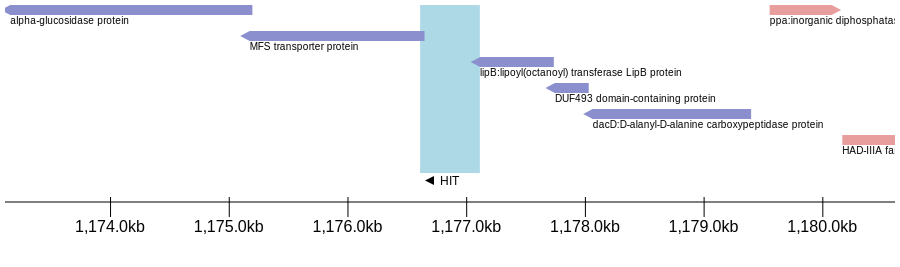

---

Match #605
E-value:          1.7999999999999977e-130
%GC:              0.26
Score:            449.3
Target:           NC_017450.1/963040-963538
Genome Assembly:  GCF_000195535.1_ASM19553v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: AUUAUAGUUUUUAUUAAUUAAACUCAUCUUCAAUUUCAGUUUGUUGACUUGCAACGAUAUUCUUGGCAAUAGUAACUCCUUUCAUCUUAAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCCCCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCCAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


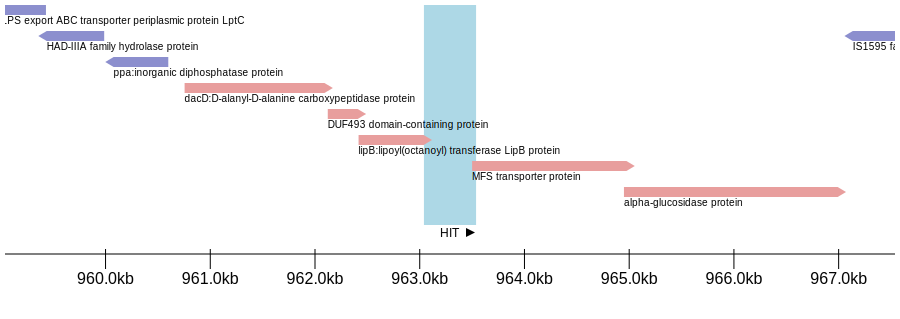

---

Match #606
E-value:          1.6999999999999972e-129
%GC:              0.26
Score:            446.2
Target:           NZ_DS989818.1/700908-701427
Genome Assembly:  GCF_000155755.1_FTE_ASSEMBLY
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUAUAGCAAAAUAAUCAAGUaauaacaaaagcuUAUUAGAAAAAUUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCUAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUACCACUAAAUAUAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUuUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


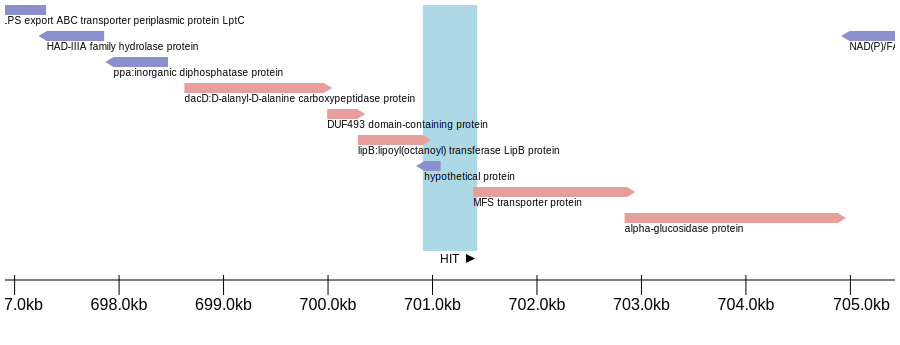

---

Match #611
E-value:          1.9e-129
%GC:              0.27
Score:            446.0
Target:           NZ_DS995363.1/558307-558824
Genome Assembly:  GCF_000156415.1_ASM15641v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGUaauaacaaaagcuUAUUAGAAAAAUUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCCAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUuUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


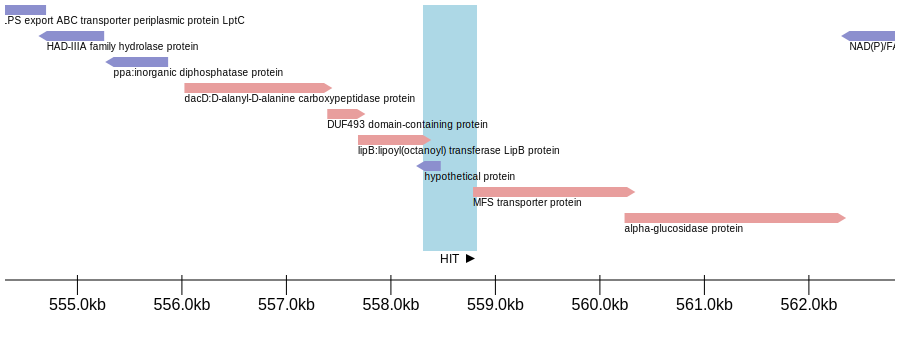

---

Match #612
E-value:          9.399999999999999e-128
%GC:              0.27
Score:            440.4
Target:           NZ_CP016635.1/970401-970914
Genome Assembly:  GCF_001865695.1_ASM186569v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUAAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGUaauaacaaaagcuUAUUAGAAAAAUUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUCUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCCAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


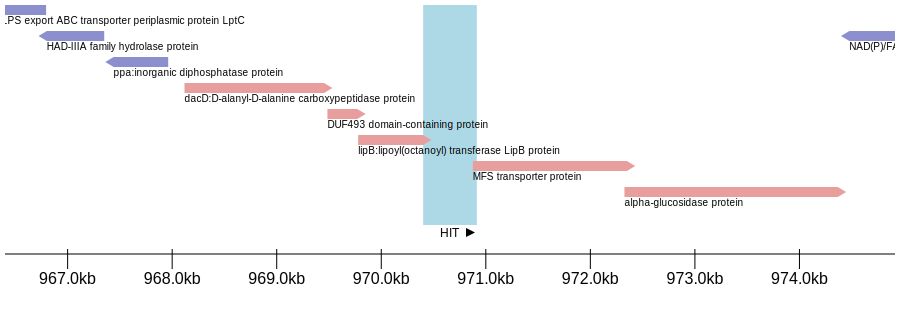

---

Match #613
E-value:          1.1999999999999979e-122
%GC:              0.25
Score:            423.7
Target:           NZ_DS264589.1/544223-544758
Genome Assembly:  GCF_000154265.1_ASM15426v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: AUUAUAGUUUUUAUUAAUUAAACUCAUCUUCAAUUUCAGUUUGUUGACUUGCAAUGAUAUUCUUGGCAAGAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGAaauaacaaaagcuUAUUAGAAAAAAUUUUUCUACCCACCUAUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAUAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUAGUUAAUUAAUUgauuugucuaugauuuaugcUUAAGGGAUCACCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAUCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUAACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


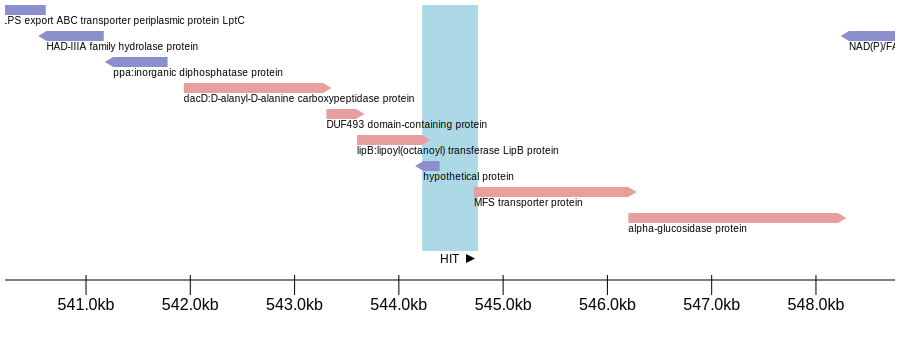

---

Match #615
E-value:          2.6999999999999963e-122
%GC:              0.26
Score:            422.5
Target:           NZ_JRXS01000006.1/1206735-1206200
Genome Assembly:  GCF_001870885.1_FAK_1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; unclassified Francisella
Matched Sequence: AUUAUAGUUUUUAUUAAUUAAACUCAUCUUCAAUUUCAGUUUGUUGACUUGCAAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUCACAUUUACAGCAAAAUAAUCAAGAaauaacaaaagcuUAUUAGAAAAAAUUUUUCUACCCACCUAUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGCUAAUUAAUUgauuugucuaugguuuaugcUUAAGGGAUCACCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAAAUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCGUUUCUUAAUAAUACUAUAAUCCAUUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCCAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUAACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


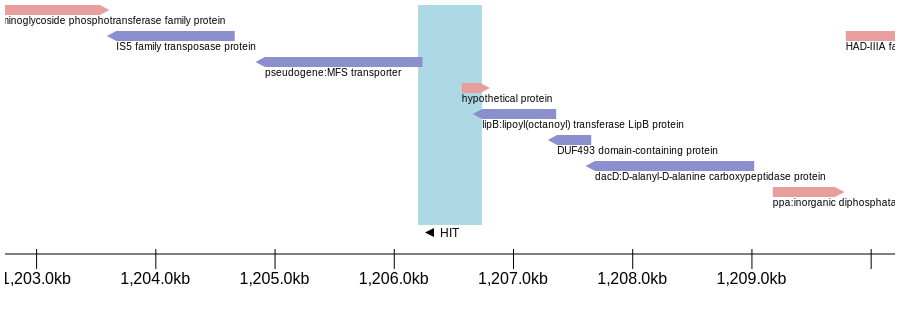

---

Match #616
E-value:          1.699999999999998e-120
%GC:              0.29
Score:            416.6
Target:           NZ_CP007148.1/1009172-1008665
Genome Assembly:  GCF_000524575.1_ASM52457v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. holarctica
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUACUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUAUGUUAUAGGGAUGGGUGACAUUUUUGGUGGAGAGUGCUUUUUUAGCAUUAGGUGAUUCUauCACUAAAUACAUAUGUUAUGG


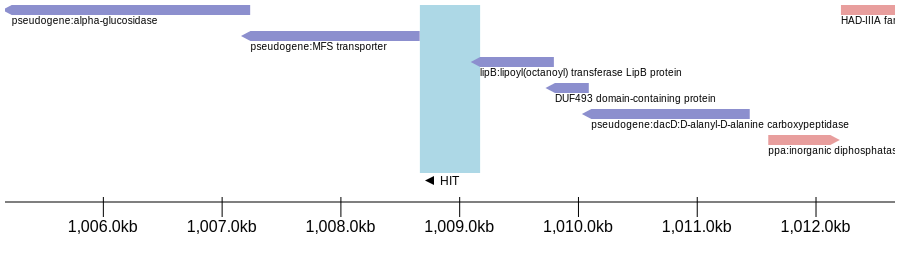

---

Match #617
E-value:          2.6e-116
%GC:              0.28
Score:            402.9
Target:           NZ_CP012092.1/422335-421902
Genome Assembly:  GCF_001412545.1_ASM141254v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUACUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUAUGUUAUGG


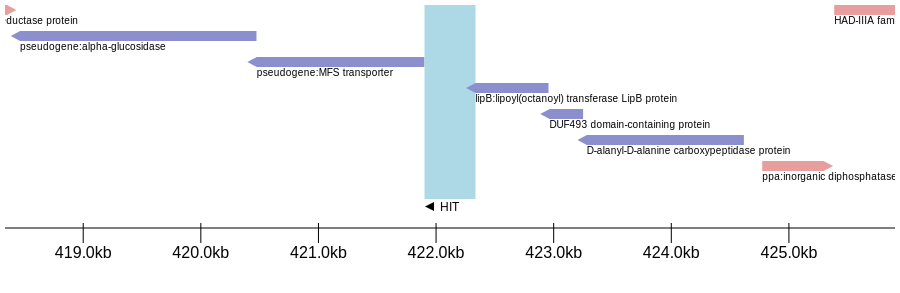

---

Match #618
E-value:          5.799999999999988e-116
%GC:              0.28
Score:            401.8
Target:           NZ_JUJU01000001.1/587740-587307
Genome Assembly:  GCF_000833715.1_FTT_3
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCCUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUACUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUAUGUUAUGG


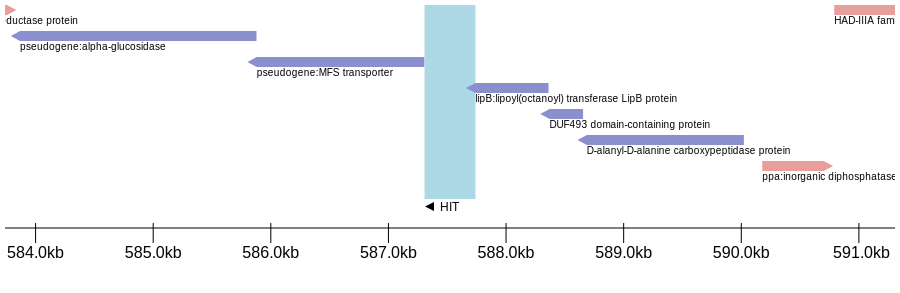

---

Match #621
E-value:          1.799999999999998e-115
%GC:              0.28
Score:            400.1
Target:           NZ_DS264138.1/348970-348538
Genome Assembly:  GCF_000154145.1_ASM15414v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. holarctica
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCCUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUACUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUAUGUUAUG


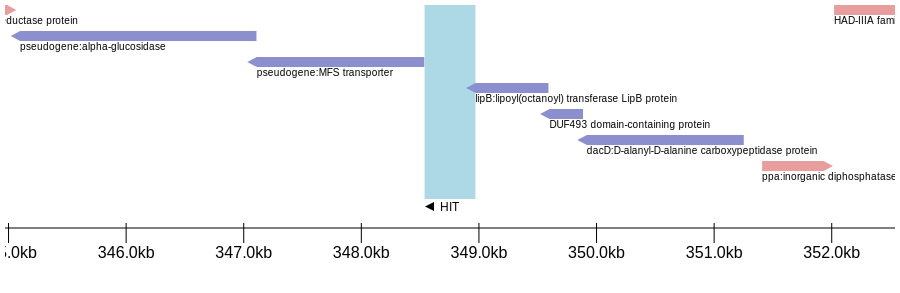

---

Match #622
E-value:          1.899999999999998e-108
%GC:              0.25
Score:            377.1
Target:           NC_017449.1/892786-892241
Genome Assembly:  GCF_000195555.1_ASM19555v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella
Matched Sequence: AUUAUAGUUUUUAUUAAUUAAUCUCAUUUUCAAUUUCAGCUUAUUGAUUUGCAAUGAUAUUcuCUUGGCAAUAGUAACUUCUUGCAUCUUccuaaagACAUCCAAGGCUgcaAUUGCUGACAUUUACAGCAAAAUAAUUAAGAaaugacaaaagauUAUUAGAAAAAAUUUUUCUACCCACUUAUUUUUUUGAUUUACAAUUUAGUUUUAGCACUGAAGAUUUAUUUAUUAUACUAAGAUUAUUUAAUGUCUACAAAGCAAGCUCUUGGCUAAUcaauUGAUUuaucuaugguuuaugcUUAAGGAAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUGCCACAAAGAGUACUUUUUUGCAAAAAUUAAAAUUUAGAAAUUACAUAUGUUAUGG


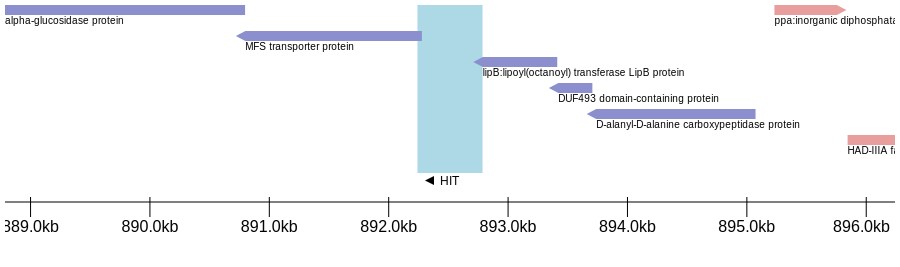

---

Match #623
E-value:          3.099999999999998e-95
%GC:              0.25
Score:            333.8
Target:           NZ_QDDU01000093.1/807-438
Genome Assembly:  GCF_003417005.1_ASM341700v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Enterobacterales; Enterobacteriaceae; Klebsiella
Matched Sequence: UAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAAAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUACUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


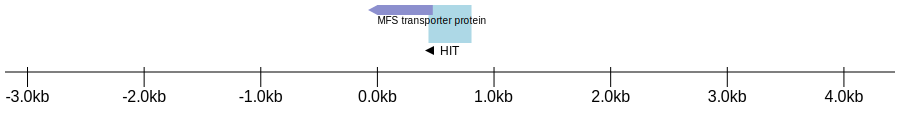

---

Match #624
E-value:          2.1e-93
%GC:              0.28
Score:            327.8
Target:           NZ_LUFR01000017.1/16124-15591
Genome Assembly:  GCF_001608445.1_FHIS001-SEQ-1-ASM-1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella hispaniensis
Matched Sequence: AUUAUAGUUUUUAUUAAUUAAUCUCAUCUUCAACUUGAGCUUGUUGAGUUGCAAUGAUAUUcuCUUGGCAAUAGUAACUUCUUGCAUCUUccuaaagACAUCCAAGGCUgcAUUGCUGACAUUUACAGAAAAAUACUCAucaAAAuaacaaaagcuUAUUAUAAAAAACUUUUCUACCCACUUAUUUCUUUUGAUUUACAAUUUAGUUUUAGUACUGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGCAAGCUCUUGGCUAAUcaauUGAUUuaucugugguuuaugcUUAAGGGAUCGCCAAGUUUAGCUUUUUCUGCaUAAUAGUUGGUAUUUGAGUUGCACAUCAAAGAAUAAACAAGAAUCUUUUAUAAAUUAUAAGCUACUUCAGUUAACCGGUAUUUUUUGCUGGACCAUUAGGUGAUUCUAUUGCUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUGUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


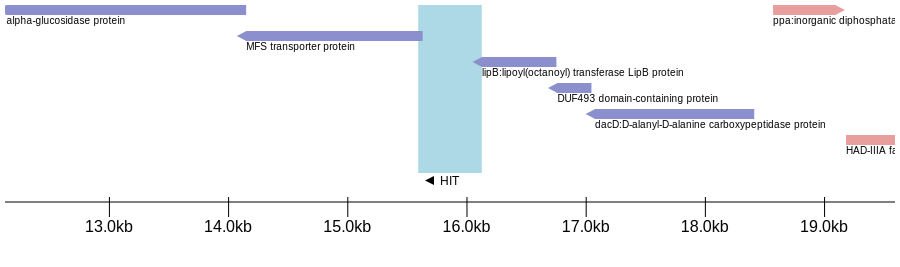

---

Match #626
E-value:          8.300000000000001e-74
%GC:              0.25
Score:            263.5
Target:           NZ_CP009353.1/1675087-1674655
Genome Assembly:  GCF_000833165.1_ASM83316v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: AAAUGCUGAUAUGAAACACAAAAUAAGGAUUUUUAAGUUGGAUUUCUCUAAAAAUAUcuaAAAUCAAUAGguauaAGAAAAAUCUUAGAUUAACucaACAGCCUUUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUAGUUAAUUAAUUgauuugucuaugauuuaugcUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


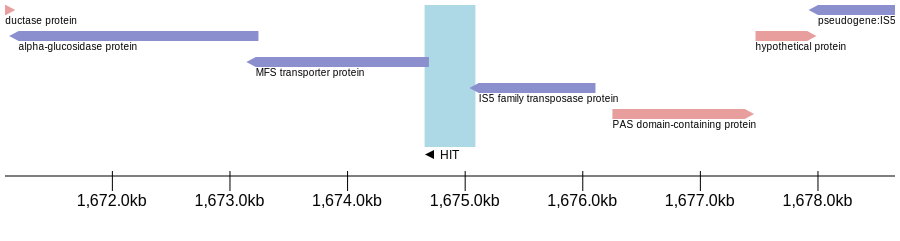

---

Match #628
E-value:          5.000000000000003e-72
%GC:              0.25
Score:            257.6
Target:           NZ_DS264128.1/487427-487858
Genome Assembly:  GCF_000154185.1_ASM15418v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: AAUGCUGAUAUGAAACACAAAAUAAGGAUUUUUAAGUUGGAUUUCUCUAAAAAUAUcuaAAAUCAAUAGguauaAGAAAAAUCUUAGAUUAACucaACAGCCUUUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUAGUUAAUUAAUUgauuugucuaugauuuaugcUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


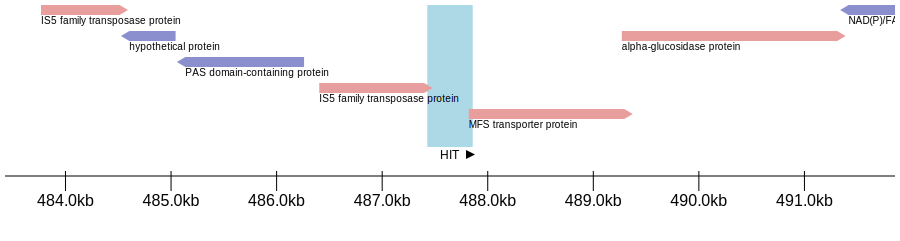

---

Match #629
E-value:          2.1e-71
%GC:              0.24
Score:            255.6
Target:           NZ_CP010103.1/1109133-1108701
Genome Assembly:  GCF_000834965.1_ASM83496v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis
Matched Sequence: AAAUGCUGAUAUGAAACACAAAAUAAGGAUUUUUAAGUUGGAUUUCUCUAAAAAUAUcuaAAAUCAAUAGguauaAGAAAAAUCUUAGAUUAACucaACAGCCUUUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUAGUUAAUUAAUUgauuugucuaugauuuaugcUUAAGGGAUCACCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAUCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUAACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


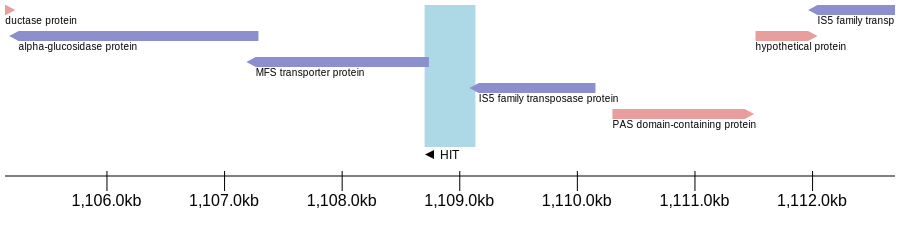

---

Match #630
E-value:          9.999999999999994e-71
%GC:              0.24
Score:            253.4
Target:           NZ_KN046811.1/1797565-1797204
Genome Assembly:  GCF_000742085.1_ASM74208v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis
Matched Sequence: UAUAAGAAAAAUCUUAGAUUAACucaACAGCCUUUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUAGUUAAUUAAUUgauuugucuaugauuuaugcUUAAGGGAUCACCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAUCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUAACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


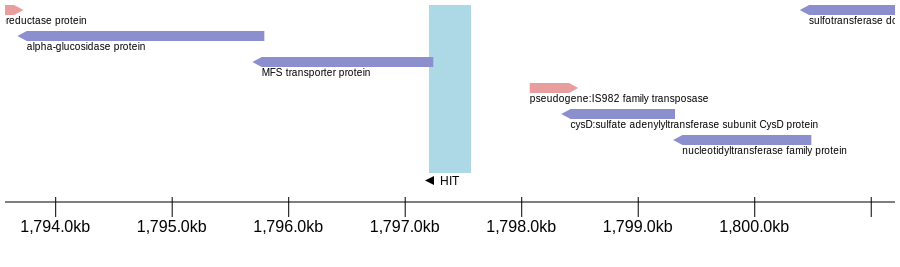

---

Match #631
E-value:          3.1999999999999996e-41
%GC:              0.28
Score:            156.6
Target:           NZ_DS264128.1/434759-434517
Genome Assembly:  GCF_000154185.1_ASM15418v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAguauaGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGAaauaacaaaagcuUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAUAUUUAUAAGACUGUUGAUUUAAUCUGCA


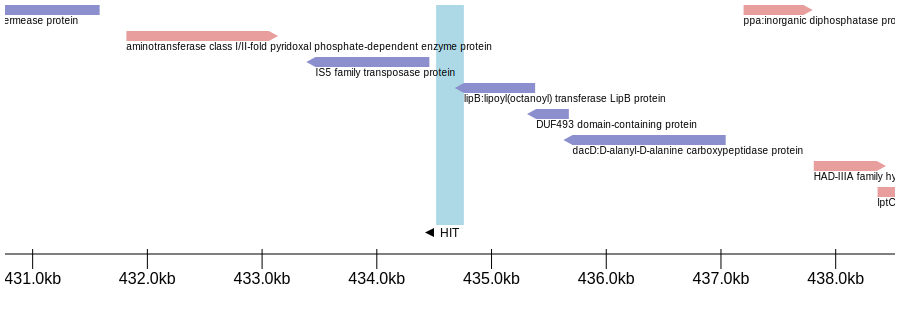

---

Match #632
E-value:          2.6e-39
%GC:              0.25
Score:            150.3
Target:           NZ_CP009353.1/1727757-1728063
Genome Assembly:  GCF_000833165.1_ASM83316v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAguauaGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGAaauaacaaaagcuUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAUAUUUAUAAGACUGUUGAUUUAAUCUGcaAAUAAAUUUAUGAAUUUUGUAAAAUAUAGAUAUAGUAGAUaUUUAUAUUUUAAUAAUUAUGGAU


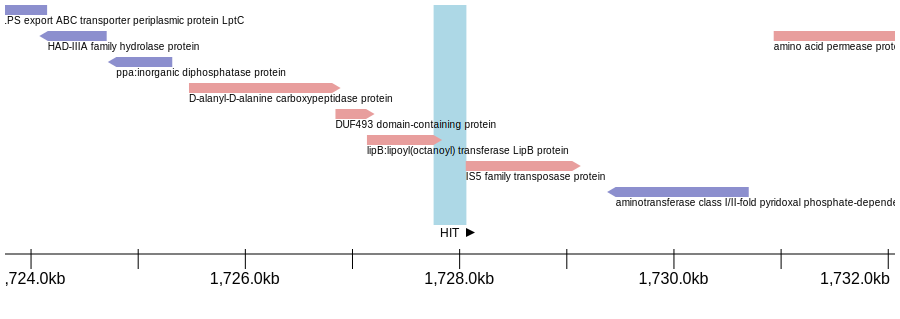

---

Match #634
E-value:          9.6e-38
%GC:              0.25
Score:            145.2
Target:           NZ_KN046811.1/1634101-1634406
Genome Assembly:  GCF_000742085.1_ASM74208v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAguauaGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGAaauaacaaaagcuUAUUAGAAAAAAUUUUUCUACCCACCUAUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAUAUUUAUAAGACUGUUGAUUUAAUCUGcaAAUAAAUUUAUGAAUUUUGUAAAAUAUAGAUAUAGUAGAUaUUUAUAUUUUAAUAAUUAUGGAU


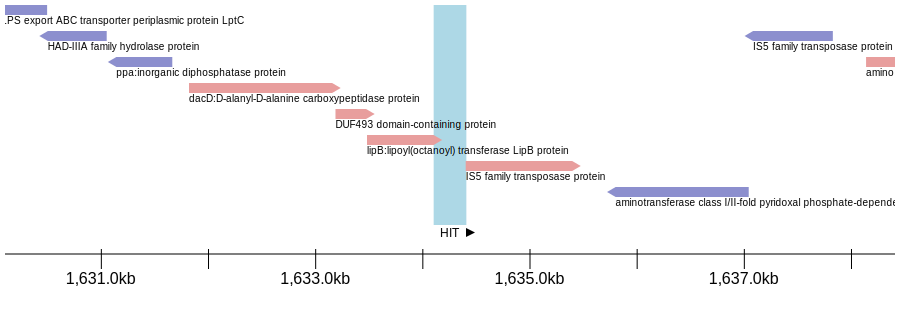

---

Match #636
E-value:          0.0071
%GC:              0.25
Score:            30.8
Target:           NZ_VXKQ01000016.1/59708-59567
Genome Assembly:  GCF_008711465.1_ASM871146v1
Lineage:          cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; unclassified Francisella
Matched Sequence: UUUUUUUGCUAAAACAUCAGGUGACUAUAAUGUAAAAUAUCUUUAUUCUAUAGCAAAacucuuaaugacUUUAcccAGUAUUUaaaacUACAAGGAGUAUUCUUUUGCAAAAUUUAAAACUCAGAAACUAUAUAUCUUAUGG


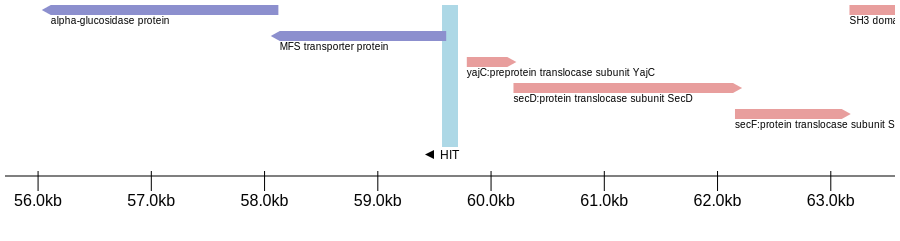

In [8]:
deduped_sto_records = [record for record in sto_records if re.sub('^[0-9]+\|','',record.id) in dedupe_id_list]
results_csv_filename = "{}/{}_results.csv".format(outdir, motif_name)
if not os.path.exists(results_csv_filename):
    deduped_results_df['lineage']=''
    deduped_results_df['assembly_accession']=''
    deduped_results_df.to_csv(results_csv_filename)
get_all_images(results_csv_filename, deduped_sto_records)